In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pickle
import pandas as pd
import seaborn as sns
import os
import configs

from Model import Model
from PlaceInputs import PlaceInputs
from utils import *
import configs

# Unpack experiments

In [35]:
# Specify what you're looking at
exp = 'weight_bias'
search_style = 'wide'

In [36]:
exp_dir = f'/Volumes/aronov-locker/Ching/barcodes/3cache_task/{exp}/'
N_inp = 2000
N_bar = 2000
num_states = 100
cache_states = [20, 30, 70]
inputs = PlaceInputs(N_inp, num_states).get_inputs()

In [37]:
def get_reconstruct_stats(reconstruct):
    argmax_v = np.argmax(reconstruct, axis=1)
    argmax_v = (argmax_v/N_inp)*num_states
    max_v = np.max(reconstruct, axis=1)
    threshold_scale = 1.
    threshold = reconstruct.mean()+threshold_scale*reconstruct.std()

    attractor_dist = []
    opt_attractor_dist = []
    attractor_locs = []
    attractor_validity = []
    state_locs = []
    for loc, _v in enumerate(argmax_v):
        if max_v[loc] < threshold:
            _v = -1
        _opt_dist = min([distance(loc, c, num_states) for c in cache_states])
        opt_attractor_dist.append(_opt_dist)
        state_locs.append(loc)
        if _v in cache_states:
            attractor_dist.append(distance(loc, _v, num_states))
            if _opt_dist > distance(loc, _v, num_states):
                import pdb; pdb.set_trace()
            attractor_locs.append(_v)
            attractor_validity.append(1)
        else:
            attractor_dist.append(np.nan)
            attractor_locs.append(np.nan)
            attractor_validity.append(-1)
    attractor_dist = np.array(attractor_dist)
    attractor_locs = np.array(attractor_locs)
    attractor_validity = np.array(attractor_validity)
    opt_attractor_dist = np.array(opt_attractor_dist)
    state_locs = np.array(state_locs)
    return attractor_dist, attractor_locs, attractor_validity, opt_attractor_dist, state_locs

In [38]:
results_1 = {
    'param': [],
    'seed': [],
    'valid_attractors': [],
    'valid_20_30_attractors': [],
    }
results_2A = {
    'param': [],
    'seed': [],
    'opt attractor dist': [],
    'probability': []
    }
results_2B = {
    'param': [],
    'seed': [],
    'opt attractor dist': [],
    'chosen attractor dist': []
    }
results_2C = {
    'param': [],
    'seed': [],
    'cache': [],
    'probability': [],
    }
results_3 = {
    'param': [],
    'seed': [],
    'distance': [],
    'barcode corr': []
    }
results_4 = {
    'param': [],
    'seed': [],
    'place-barcode corr': []
    }

for param in os.listdir(exp_dir):
    if param == '.DS_Store': continue
    for seed in os.listdir(exp_dir + param):
        if seed == '.DS_Store': continue
        _exp_dir = exp_dir + param + '/' + seed + '/'
        with open(_exp_dir + 'results.p', 'rb') as f:
            _results = pickle.load(f)
        attractor_dist, attractor_locs, attractor_validity, opt_attractor_dist, state_locs = \
            get_reconstruct_stats(_results[f'{search_style}_reconstruct'])
        
        # Test 1
        valid = np.sum(attractor_validity==1)/attractor_validity.size
        v = attractor_validity[np.logical_and(state_locs>20, state_locs<30)]
        valid_20_30 = np.sum(v==1)/v.size
        results_1['param'].append(float(param))
        results_1['seed'].append(seed)
        results_1['valid_attractors'].append(valid)
        results_1['valid_20_30_attractors'].append(valid_20_30)
        
        # Test 2A
        for _opt_dist in np.sort(np.unique(opt_attractor_dist)):
            idxs = opt_attractor_dist==_opt_dist
            _validity = attractor_validity[idxs]
            valid = np.sum(_validity==1)/_validity.size
            results_2A['param'].append(float(param))
            results_2A['seed'].append(seed)
            results_2A['opt attractor dist'].append(_opt_dist)
            results_2A['probability'].append(valid)
            
        # Test 2B
        attractor_dist = attractor_dist[attractor_validity==1]
        attractor_locs = attractor_locs[attractor_validity==1]
        opt_attractor_dist = opt_attractor_dist[attractor_validity==1]
        for _opt_dist in np.sort(np.unique(opt_attractor_dist)):
            idxs = opt_attractor_dist==_opt_dist
            _chosen_dist = np.mean(attractor_dist[idxs]) - _opt_dist
            results_2B['param'].append(float(param))
            results_2B['seed'].append(seed)
            results_2B['opt attractor dist'].append(_opt_dist)
            results_2B['chosen attractor dist'].append(_chosen_dist)
            
        # Test 2C
        for idx, cache_state in enumerate(cache_states):
            p = np.sum(attractor_locs==cache_state)/attractor_locs.size
            results_2C['param'].append(float(param))
            results_2C['seed'].append(seed)
            results_2C['cache'].append(cache_state)
            results_2C['probability'].append(p)
            
        # Test 3
        acts = _results[f'{search_style}_acts']
        c = pairwise_correlations_centered(acts)
        distances = []; correlations = []
        for i in range(c.shape[0]):
            for j in range(c.shape[1]):
                distances.append(distance(i, j, num_states))
                correlations.append(c[i,j])
        distances = np.array(distances); correlations = np.array(correlations)
        for _dist in np.unique(distances):
            idxs = distances==_dist
            _corr = np.mean(correlations[idxs])
            results_3['param'].append(float(param))
            results_3['seed'].append(seed)
            results_3['distance'].append(_dist)
            results_3['barcode corr'].append(_corr)
            
        # Test 4
        acts_normalized = normalize(acts)
        inputs_normalized = normalize(inputs)
        corrs = [np.corrcoef(acts_normalized[i], inputs_normalized[i])[0, 1] for i in range(num_states)]
        results_4['param'].append(float(param))
        results_4['seed'].append(seed)
        results_4['place-barcode corr'].append(np.mean(corrs))

# Test 1

In [39]:
import importlib
importlib.reload(configs)

<module 'configs' from '/Users/chingfang/Code/barcodes/configs.py'>

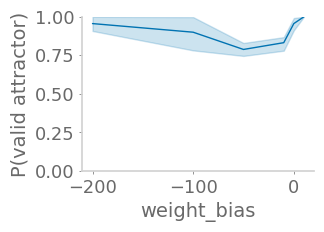

In [40]:
data = pd.DataFrame(results_1)

plt.figure(figsize=(3,2))
sns.lineplot(x='param', y='valid_attractors', data=data)
plt.xlabel(exp)
plt.ylabel('P(valid attractor)')
plt.ylim(0, 1.0)
plt.show()

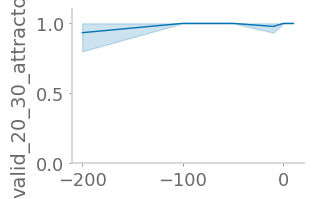

In [41]:
plt.figure(figsize=(3,2))
sns.lineplot(x='param', y='valid_20_30_attractors', data=data)
plt.ylim(0, 1.1)
plt.xlabel('')
plt.show()

# Test 2

In [42]:
import importlib
importlib.reload(configs)

<module 'configs' from '/Users/chingfang/Code/barcodes/configs.py'>

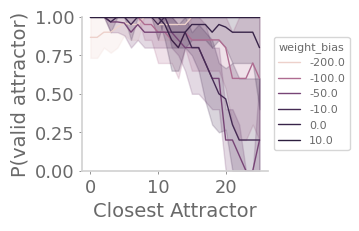

In [43]:
data = pd.DataFrame(results_2A)
plt.figure(figsize=(3,2))
sns.lineplot(x='opt attractor dist', y='probability', hue='param', data=data)
plt.ylim(0, 1.0)
plt.xlabel('Closest Attractor')
plt.ylabel('P(valid attractor)')

# Shrink current axis by 20%
ax = plt.gca()
box = ax.get_position()
ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])

# Put a legend to the right of the current axis
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5), title=exp)
plt.show()

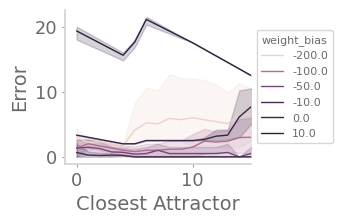

In [44]:
data = pd.DataFrame(results_2B)
plt.figure(figsize=(3,2))
sns.lineplot(x='opt attractor dist', y='chosen attractor dist', hue='param', data=data)
plt.xlim(-1, 15)
plt.xlabel('Closest Attractor')
plt.ylabel('Error')

# Shrink current axis by 20%
ax = plt.gca()
box = ax.get_position()
ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])

# Put a legend to the right of the current axis
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5), title=exp)

plt.show()

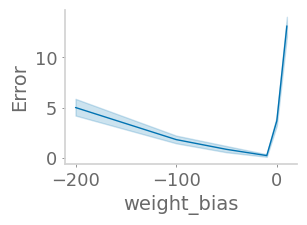

In [45]:
data = pd.DataFrame(results_2B)
plt.figure(figsize=(3,2))
sns.lineplot(x='param', y='chosen attractor dist', data=data)
plt.xlabel(exp)
plt.ylabel('Error')
plt.show()

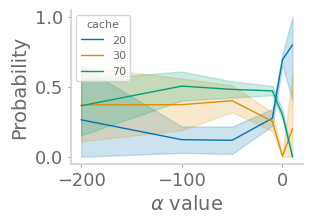

In [46]:
data = pd.DataFrame(results_2C)

plt.figure(figsize=(3,2))
sns.lineplot(x='param', y='probability', hue='cache', data=data, palette=['C0', 'C1', 'C2'])
plt.xlabel(r'$\alpha$ value')
plt.ylabel('Probability')
plt.show()

# Test 3

In [47]:
data = pd.DataFrame(results_3)

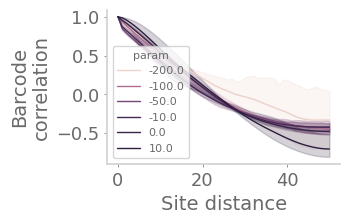

In [48]:
plt.figure(figsize=(3,2))
sns.lineplot(x='distance', y='barcode corr', hue='param', data=data)
plt.xlabel('Site distance')
plt.ylabel('Barcode\ncorrelation')
plt.show()

# Test 4

In [49]:
data = pd.DataFrame(results_4)

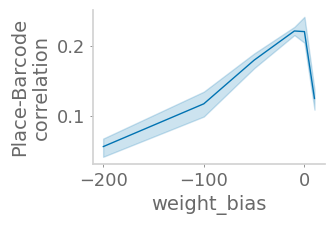

In [50]:
plt.figure(figsize=(3,2))
sns.lineplot(x='param', y='place-barcode corr', data=data)
plt.xlabel(exp)
plt.ylabel('Place-Barcode\ncorrelation')
plt.show()